# 1. Import and Preprocess the Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.interpolate as sci
import plotly.express as px

In [2]:
# Session 1: Importing prime matrix into Python
price_matrix = pd.read_csv("prices.csv", sep=";", index_col="Date")

price_matrix.head(3)

,MCD,WMT,KO,T,BAC,KHC,BA,TSLA,AMZN,AAPL,VZ,PFE,GS,MMM,AXP,CAT,FCAU,UL,COST,XOM
Date,,,,,,,,,,,,,,,,,,,,
1/12/2015,104.43,54.14,36.75,25.93,15.30,59.40,128.68,48.00,675.89,24.18,37.01,25.39,166.31,131.36,64.08,57.74,7.3,36.8,147.4,61.5
1/1/2016,109.41,59.10,36.72,27.17,12.89,64.25,106.91,38.24,587.00,22.36,40.01,23.99,149.08,131.68,49.29,52.88,5.6,37.8,137.9,61.5
1/2/2016,103.59,59.09,36.90,28.23,11.42,63.40,105.18,38.39,552.52,22.21,41.12,23.34,137.98,136.80,51.43,59.00,5.5,36.5,136.9,63.3


In [3]:
# Session 2: Return Matrix
n = len(price_matrix)
monthly_returns = price_matrix.pct_change().dropna(axis = 0, how = 'any', inplace = False)
monthly_returns.head(3)

,MCD,WMT,KO,T,BAC,KHC,BA,TSLA,AMZN,AAPL,VZ,PFE,GS,MMM,AXP,CAT,FCAU,UL,COST,XOM
Date,,,,,,,,,,,,,,,,,,,,
1/1/2016,0.047687,0.091614,-0.000816,0.047821,-0.157516,0.081650,-0.169179,-0.203333,-0.131515,-0.075269,0.081059,-0.055140,-0.103602,0.002436,-0.230805,-0.084170,-0.232877,0.027174,-0.064450,0.000000
1/2/2016,-0.053194,-0.000169,0.004902,0.039014,-0.114042,-0.013230,-0.016182,0.003923,-0.058739,-0.006708,0.027743,-0.027095,-0.074457,0.038882,0.043417,0.115734,-0.017857,-0.034392,-0.007252,0.029268
1/3/2016,0.080510,0.032324,0.075610,0.060220,0.079685,0.019874,0.084046,0.196926,0.074423,0.133273,0.066148,0.008997,0.054356,0.069883,0.104803,0.130678,0.163636,0.063014,0.053324,0.052133


In [4]:
# Session 3: Portfolio expected return and standard deviation
average_monthly_returns = monthly_returns.mean(axis=0)
# print(annual_returns.sort_values(ascending= False))
print(average_monthly_returns)

MCD     0.013378
WMT     0.018701
KO      0.007577
T       0.003468
BAC     0.014175
KHC    -0.005958
BA      0.015274
TSLA    0.051507
AMZN    0.029626
AAPL    0.031081
VZ      0.009635
PFE     0.007469
GS      0.008757
MMM     0.006450
AXP     0.013218
CAT     0.021409
FCAU    0.021754
UL      0.009588
COST    0.017407
XOM    -0.005187
dtype: float64


<Axes: >

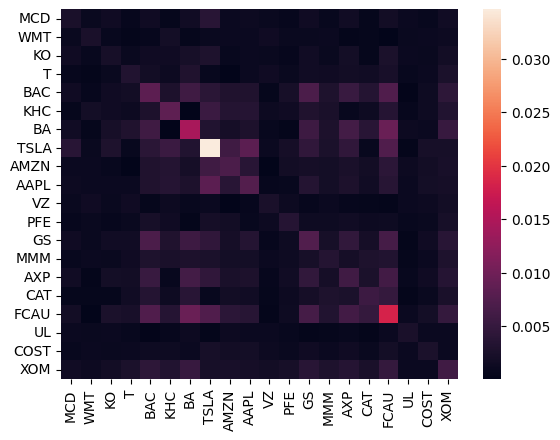

In [5]:
# covariance matrix of expected returns
monthly_cov = monthly_returns.cov()

sns.heatmap(monthly_cov)

==> TSLA: higher return comes with higher variance

# Monte Carlo Simulation


First, we will conduct a simulation with 100,000 pairs of randomized weights, then calculate the risk and expected return of the coresponding portfolio. The  graph would depict the feasible market portfolio region.


In [6]:
rfr = 0.0221/12

def porfolio_returns(weights):
  """
  Input: weights: vector of 20 weights shape = (20,)
  """
  return np.dot(weights, average_monthly_returns)
def porfolio_sd(weights):
  """
  Input: weights: vector of 20 weights shape = (20,)
  """
  return np.sqrt(np.dot(np.dot(weights, monthly_cov), weights.T))

def subtract_sharpe_fun(weights):
  return -(porfolio_returns(weights) - rfr)/porfolio_sd(weights)

** Một lưu ý nhỏ ở đây: Hiện ở trên, mìnnh đang tính ở mức độ monthly, nhưng nếu tính ở mức độ annualized, sử dụng rfr=0.0221, thì annualized_return = monthly_return x 12 và annualized_cov= monthly_cov x 12 (annualized sd = month_sd x 12)
Đây là cách tính lãi của ngân hàng, không phải kiểu thống kê (annualized_cov= monthly_cov x 12^2)

In [7]:
# set a initial weights to be startign point for out optimization problem
equal_weights = np.array([1 / 20] * 20)
print(porfolio_returns(equal_weights))
print(porfolio_sd(equal_weights))

0.014466413203407741
0.04803250158885294


Desriptive summary of the sharpe ratios of the randomly generated portfolios
count    100000.000000
mean          0.258470
std           0.030187
min           0.124383
25%           0.238176
50%           0.259037
75%           0.279180
max           0.381783
dtype: float64
Best performance among the randomized weights

  Sharpe Ratio: 0.3818
  Annualized Expected Return (%): 0.0204
  Annualized Risk (%): 0.0485


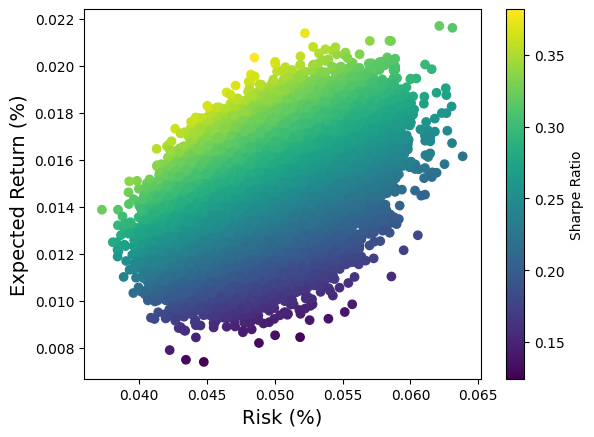

In [8]:
ret = []
std = []
num_simulation = 100000
num_funds = len(monthly_cov)

# initialize the weigts
W = np.random.uniform(0,1, (num_simulation,num_funds))
for i in range(num_simulation):
  w = W[i]
  if sum(w): # ensure at least one w[i] != 0
    w = w/ np.sum(w)
  else: # if all w[i] == 0, initialize a new weights set
    w = np.random.uniform(0,1, (num_funds,))
    w = w/ np.sum(w)
  ret.append(porfolio_returns(w))
  std.append(porfolio_sd(w))

sharpe = np.add(ret, -rfr) / std
print('Desriptive summary of the sharpe ratios of the randomly generated portfolios')
print(pd.Series(sharpe).describe())

print('Best performance among the randomized weights\n')
print(f'  Sharpe Ratio: {np.max(sharpe):.4f}')
print(f'  Annualized Expected Return (%): {ret[np.argmax(sharpe)]:.4f}')
print(f'  Annualized Risk (%): {std[np.argmax(sharpe)]:.4f}')

plt.figure()
scatter = plt.scatter(std, ret, c=sharpe, cmap='viridis')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.ylabel('Expected Return (%)', fontsize=14)
plt.xlabel('Risk (%)', fontsize=14)
plt.show()

==> This simulation does not work well, the frontier is not clear. This is maybe because the weights is randomed using normal distribution, the distribution is symmetric, less chance of obtaining the case of lowest risk in each case of expected return.
==> try using uniform distribution, as well as, force certain number of weights to be equal 0, make the distribution less symmetric.

Desriptive summary of the sharpe ratios of the randomly generated portfolios
count    100000.000000
mean          0.248046
std           0.054393
min          -0.090831
25%           0.212698
50%           0.249989
75%           0.285090
max           0.460154
dtype: float64
Best performance among the randomized weights

  Sharpe Ratio: 0.4602
  Annualized Expected Return (%): 0.0244
  Annualized Risk (%): 0.0489


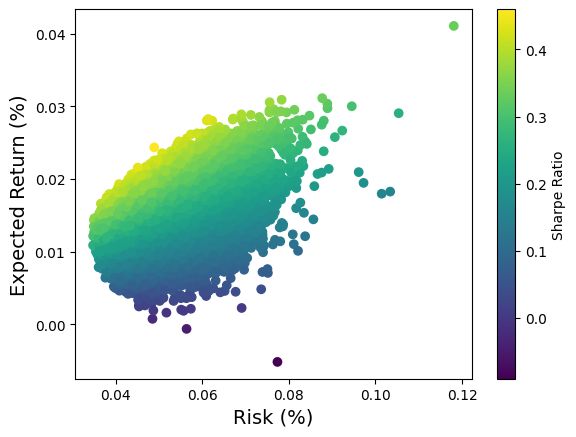

In [9]:
ret = []
std = []
num_simulation = 100000
num_funds = len(monthly_cov)

W = np.random.uniform(0,3, (num_simulation,num_funds))
for i in range(num_simulation):
  w = W[i]
  if sum(w):
    for i in range(len(w)):
      if w[i]<1.5: # force some certain weights to be zero
        w[i]=0
    w = w/ np.sum(w)
  else:
    w = np.random.uniform(0,1, (num_funds,))
    for i in range(len(w)):
      if w[i]<1: # force some certain weights to be zero
        w[i]=0
    w = w/ np.sum(w)
  ret.append(porfolio_returns(w))
  std.append(porfolio_sd(w))

sharpe = np.add(ret, -rfr) / std
print('Desriptive summary of the sharpe ratios of the randomly generated portfolios')
print(pd.Series(sharpe).describe())

print('Best performance among the randomized weights\n')
print(f'  Sharpe Ratio: {np.max(sharpe):.4f}')
print(f'  Annualized Expected Return (%): {ret[np.argmax(sharpe)]:.4f}')
print(f'  Annualized Risk (%): {std[np.argmax(sharpe)]:.4f}')

plt.figure()
scatter = plt.scatter(std, ret, c=sharpe, cmap='viridis')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.ylabel('Expected Return (%)', fontsize=14)
plt.xlabel('Risk (%)', fontsize=14)
plt.show()

==> Now the simulated shape seems to get better. The fontier is now sharper.
- Each point depicts the risk and expected return of each possible porfolio in the feasible martket portfolio space. The point is colored with the level of sharpe ratio. The lighter the point, the higher its sharpe ratio is.

=> We can predict that the location of the optimal porfolio is on the diagonal, top, left of the space.

To get a more accurate location, we will perform the optimization problem as below.

# The Optimization problem

We want to allocate the capital between these 20 assets in a way that maximizes the return of porfolio per unit of risk taken.

the chosen method: efficient frontier proposed by Markowitz (Mean-Variance framework).

The Objective  of minimizing risk given a specific level of expected return.

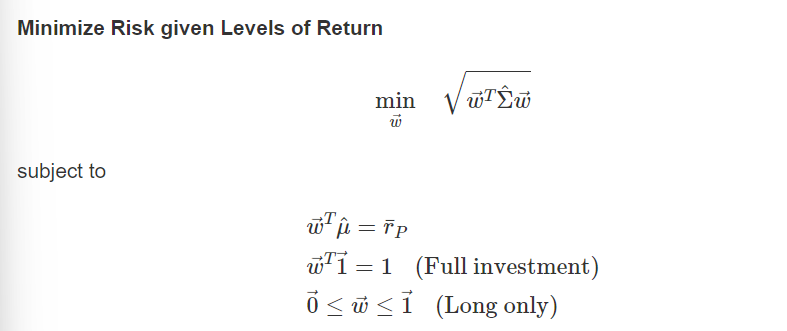

the problem of maximize expected return give a specific level of risk (rariance) is also the same.

We will optimize the weights to get the goal.

# Monte Carlo Simulation

# The optimal Porfolios Using Minimize the porfolio's variance approach

In [10]:
risk = []
ret = []
sharpe_ratios = []

bounds = tuple(
  (0, 1) for w in equal_weights
)

# set your own parameter: e.g. my expected min return is 0.09% per year
returns = [r*0.0001 for r in range(-100,600,1)]
for r_temp in returns:
  constraints = (
      {'type': 'ineq', 'fun': lambda x: x.min()},  # Constraint: x >= 0 for all x
      {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Constraint: sum(x) = 1
      {'type': 'eq', 'fun': lambda x: porfolio_returns(x) - r_temp}
  )
  # using Sequential Least Squares Programmming (SLSQP) method for minimization the -sharpeRatio

  min_sd_results = sco.minimize(fun = porfolio_sd,
                                  x0 = equal_weights,
                                  method = 'SLSQP',
                                  bounds = bounds,
                                  constraints = constraints)
  w_opt = min_sd_results["x"]
  risk.append(min_sd_results["fun"])
  ret.append(porfolio_returns(w_opt))
  sharpe_ratios.append(-subtract_sharpe_fun(w_opt))

# print('optimal risk (%):', risk_opt)
# print('expected return at optimal risk (%):', w_opt@r_annualized)
# print('optimal proportion:', np.round(w_opt, 4))

In [11]:
max(sharpe_ratios)

0.4877950579612132

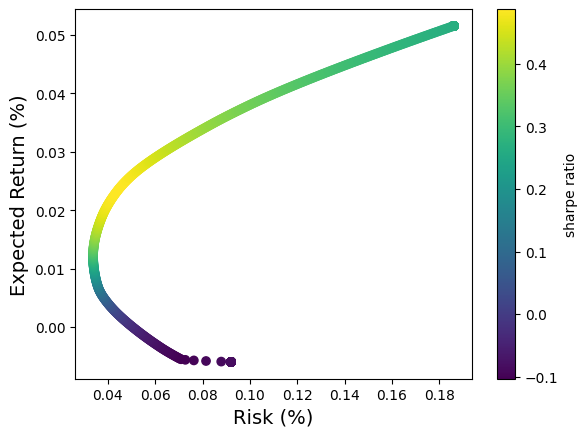

In [12]:
plt.figure()
scatter = plt.scatter(risk, ret, c=sharpe_ratios, cmap='viridis')
plt.ylabel('Expected Return (%)', fontsize=14)
plt.xlabel('Risk (%)', fontsize=14)
plt.colorbar(scatter, label='sharpe ratio')
plt.show()


==> mặc dù mình set rainge của return rộng hơn, nhưng giá trị tìm được chỉ được tối đa như hình trên, đây là giới hạn của vùng **feasible market porfolio**

Text(0.5, 1.0, 'The efficient Frontier')

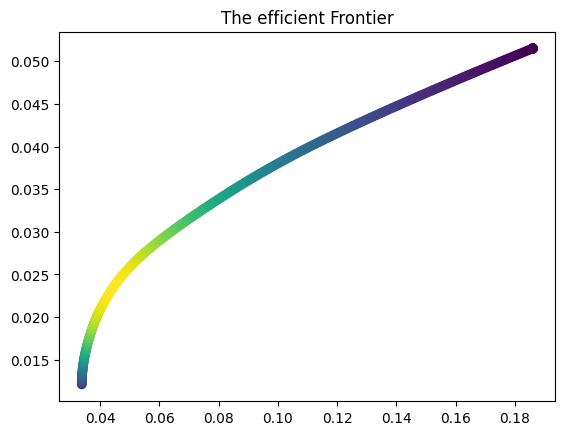

In [13]:
# vẽ đường eficient frontier
m = np.argmin(risk)
efficient_sd = risk[m:]
efficient_ret = ret[m:]
efficient_sha = sharpe_ratios[m:]
plt.scatter(efficient_sd, efficient_ret, c=efficient_sha, cmap='viridis')
plt.title("The efficient Frontier")

# The optimal Porfolio Using Maximize the Sharpe ratio porfolio approach

In [14]:
constraints = (
    {'type': 'ineq', 'fun': lambda x: x.min()},  # Constraint: x > 0 for all x
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Constraint: sum(x) = 1
)

In [15]:
# using Sequential Least Squares Programmming (SLSQP) method for minimization the -sharpeRatio
import scipy.optimize as sco
max_sharpe_results = sco.minimize(fun = subtract_sharpe_fun,
                                x0 = equal_weights,
                                method = 'SLSQP',
                                bounds = bounds,
                                constraints = constraints)

In [16]:
w_opt_sharpe = max_sharpe_results["x"]

In [17]:
import pandas as pd
w_opt_df = pd.DataFrame(np.round(w_opt_sharpe,6), index = price_matrix.columns.tolist())
w_opt_df

,0
MCD,0.000000
WMT,0.422888
KO,0.000000
T,0.000000
BAC,0.000000
KHC,0.000000
BA,0.000000
TSLA,0.067631
AMZN,0.121872
AAPL,0.090974


In [18]:
# Convert the colors to RGB format
colors_rgb = np.random.random((20,3)).tolist()

w_opt_df['c'] = colors_rgb
w_opt_df.head()

,0,c
MCD,0.000000,"[0.17713022650810917, 0.48224930965286705, 0.2..."
WMT,0.422888,"[0.1608680889540688, 0.9371973481103006, 0.960..."
KO,0.000000,"[0.20982150784758402, 0.5841385705442621, 0.72..."
T,0.000000,"[0.822386357386956, 0.8098282150610706, 0.0998..."
BAC,0.000000,"[0.5674199394130419, 0.5419443277760523, 0.581..."


<ipython-input-19-5b993b4c0da8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(w_opt_df.index, rotation=90)


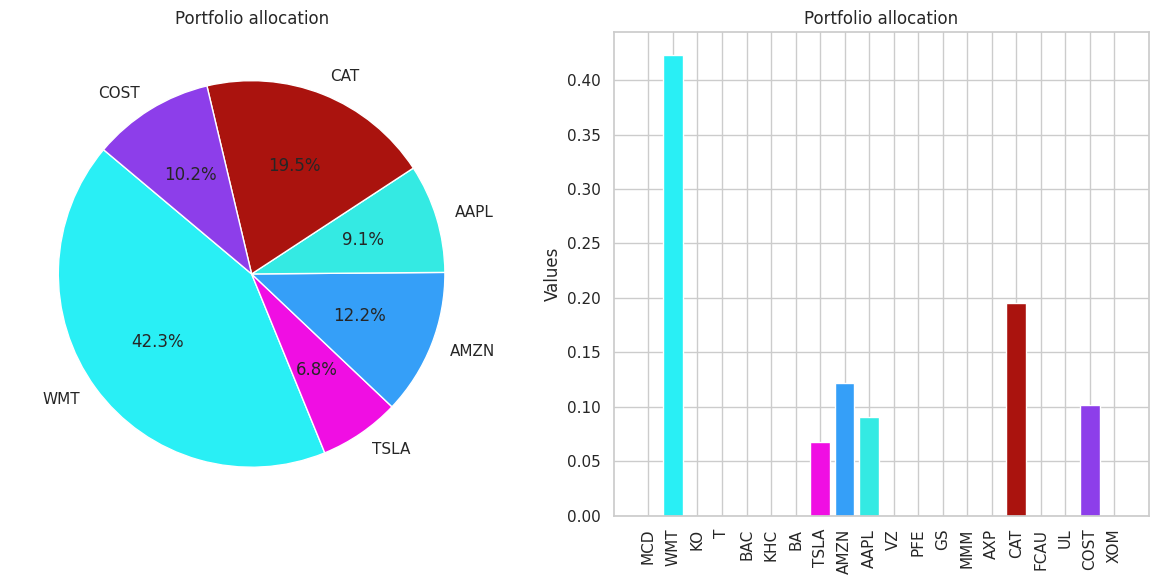

In [19]:
# Plotting
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for non-zero values
w_opt_df2 = w_opt_df[w_opt_df[0]>0]
axes[0].pie(w_opt_df2[0], labels=w_opt_df2.index, autopct='%1.1f%%', startangle=140, colors=w_opt_df2['c'])
axes[0].set_title('Portfolio allocation')

# Bar chart for zero values
axes[1].bar(w_opt_df.index, w_opt_df[0], color=w_opt_df['c']) #bar uses argument color while pie uses colors
axes[1].set_title('Portfolio allocation')
axes[1].set_ylabel('Values')
axes[1].set_xticklabels(w_opt_df.index, rotation=90)

plt.tight_layout()
plt.show()



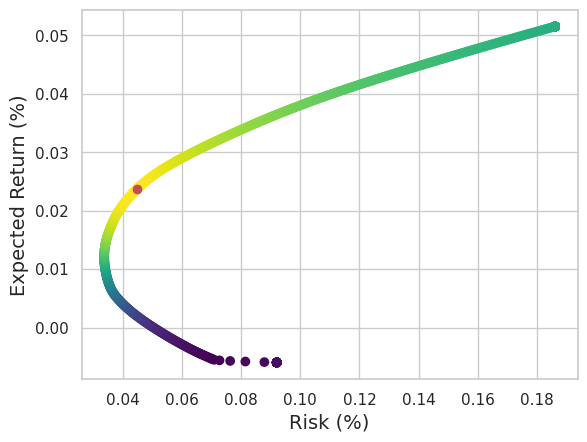

with the optimal for highest Sharpe: expected return: 0.023773142210176935 and risk: 0.044959516169214425, 
Sharpe ratio: 0.4878049723881955


In [20]:
plt.figure()
plt.scatter(risk, ret, c=sharpe_ratios, cmap='viridis')
plt.ylabel('Expected Return (%)', fontsize=14)
plt.xlabel('Risk (%)', fontsize=14)

plt.scatter(porfolio_sd(w_opt_sharpe),porfolio_returns(w_opt_sharpe), c='r')
plt.show()

print(f'with the optimal for highest Sharpe: expected return: {porfolio_returns(w_opt_sharpe)} and risk: {porfolio_sd(w_opt_sharpe)}, \nSharpe ratio: {-subtract_sharpe_fun(w_opt_sharpe)}')

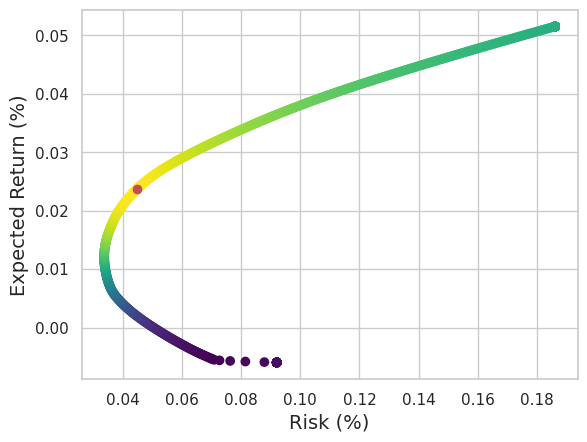

with the optimal for highest Sharpe: expected return: 0.023773142210176935 and risk: 0.044959516169214425, 
Sharpe ratio: 0.4878049723881955


In [21]:
plt.figure()
plt.scatter(risk, ret, c=sharpe_ratios, cmap='viridis')
plt.ylabel('Expected Return (%)', fontsize=14)
plt.xlabel('Risk (%)', fontsize=14)

plt.scatter(porfolio_sd(w_opt_sharpe),porfolio_returns(w_opt_sharpe), c='r')
plt.show()

print(f'with the optimal for highest Sharpe: expected return: {porfolio_returns(w_opt_sharpe)} and risk: {porfolio_sd(w_opt_sharpe)}, \nSharpe ratio: {-subtract_sharpe_fun(w_opt_sharpe)}')

# Capital Market Line
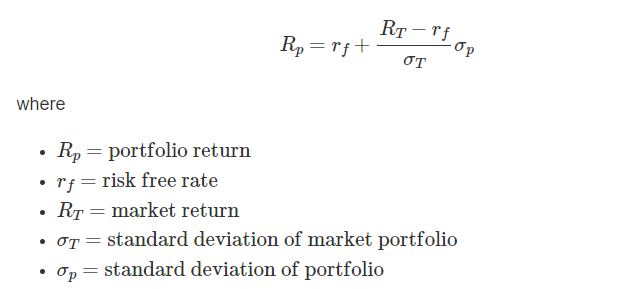


* We will use `cubic splines interpolation` to determine a smooth spline approximation of degree k on the interval xb <= x <= xe. Our goal is to obtain a continuosly differentiable functional approximation of efficient frontier.

In [22]:
tck = sci.splrep(
    x = np.sort(efficient_sd),#x is needed to be sorted
    y = efficient_ret,
    k = 3
)

In [23]:
def f(x):
  return sci.splev(
      x = x,
      tck = tck,
      der = 0
  )
def df(x):
  return sci.splev(
      x = x,
      tck = tck,
      der = 1
  )

the CML have following equation:
$g(x)=a+bx$

because $g$ tangent  with $f$ at $x => g(x) = f(x)$ and $b=g'(x)=f'(x)$

Where:

- $a=r_f$
- $b=f'(x)$

We set $a=p[0], b=p[1], x=p[2]$, we have the below system equation.

In [24]:
def sys_eq(p, rfr=0.0221/12):
  eq1 = p[0] - rfr
  eq2 = p[1] - df(p[2])
  eq3 = f(p[2]) - rfr - p[1] * p[2]
  return eq1, eq2, eq3

In [25]:
sol_set = sco.fsolve(
  # Equations to solve for
  func = sys_eq,
  # Initial guess for p
  # This can be determined by trial and error or from the plot above (may take more than one try)
  x0 = [0.0221/12, 0.1, 0.1]
)
sol_set

array([0.00184167, 0.48779514, 0.04500452])

In [26]:
# Sanity check
np.round(
  sys_eq(
    p = sol_set
  ),
  4
)

array([ 0., -0.,  0.])

In [27]:
# find tangency porfolio
constraints = (
    {'type': 'eq', 'fun': lambda x: porfolio_returns(x)-f(sol_set[2])},
    {'type': 'eq', 'fun': lambda x: x.sum()-1},
    {'type': 'ineq', 'fun': lambda x: x.min()}
)
# Optimize
min_result_object_tangency = sco.minimize(
  # Objective function
  fun = porfolio_sd,
  # Initial guess, which is the equal weight array
  x0 = equal_weights,
  method = 'SLSQP',
  bounds = bounds,
  constraints = constraints
)

In [28]:
def cml(x):
  return sol_set[0] + sol_set[1] * x


The optimal portfolio have expected return: 0.0238, sd: 0.0450, sharpe ratio: 0.4878


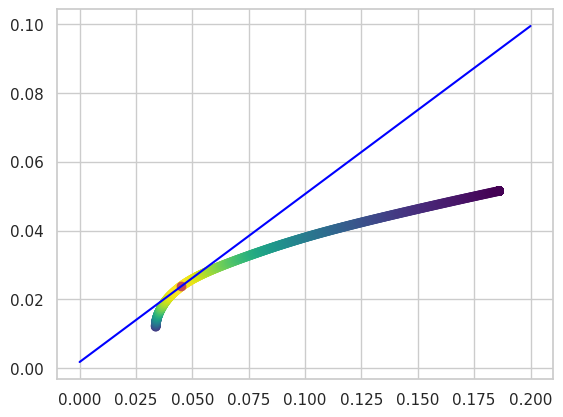

In [29]:
opt_risk = min_result_object_tangency['fun']
opt_ret = porfolio_returns(min_result_object_tangency['x'])
opt_sha =  -subtract_sharpe_fun(min_result_object_tangency['x'])
print(f'The optimal portfolio have expected return: {opt_ret:.4f}, sd: {opt_risk:.4f}, sharpe ratio: {opt_sha:.4f}')

x_values = np.linspace(0, 0.2, 100)
plt.plot(x_values, cml(x_values), label='Capital Market Line (CML)', color='blue')

plt.scatter(efficient_sd, efficient_ret, c=efficient_sha, cmap='viridis')
plt.scatter(opt_risk, opt_ret, c ='r');

In [31]:
opt_sha

0.48779549991597626